In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import math

In [24]:
df = pd.read_csv('winequality-red.csv',';')

# V.1 Exploring the green reds

#### a) Write a function that will plot a scatterplot matrix of your red wine data

In [20]:
import matplotlib.pyplot as plt

def scatterplot_matrix(data, good_threshold, bad_threshold, save_plot=False):

    numvars, numdata = data.shape
    numdata -= 1 # without quality
    
    fig, axes = plt.subplots(nrows=numdata, ncols=numdata, figsize=(18,18))
    fig.subplots_adjust(hspace=0, wspace=0)

    for ax in axes.flat:
        # Hide all ticks and labels
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    clean_data = data[(data["quality"] > good_threshold) |
                      (data["quality"] < bad_threshold)]
    colors = ['g' if k > good_threshold else 'r' if k < bad_threshold else 'white'
              for k in clean_data["quality"]]
    
    for i in range(numdata):
        axes[i,i].annotate(clean_data.columns[i], (0.5, 0.5),
            xycoords='axes fraction', ha='center', va='center')
        j = 0
        for j in range(numdata):
            if (j == i):
                continue   
            axes[i, j].scatter(clean_data.iloc[:, j], clean_data.iloc[:, i],
                               c=colors, marker='.')
    if (save_plot == True):
        plt.savefig("scatter_matrix.png")
    
    plt.show()

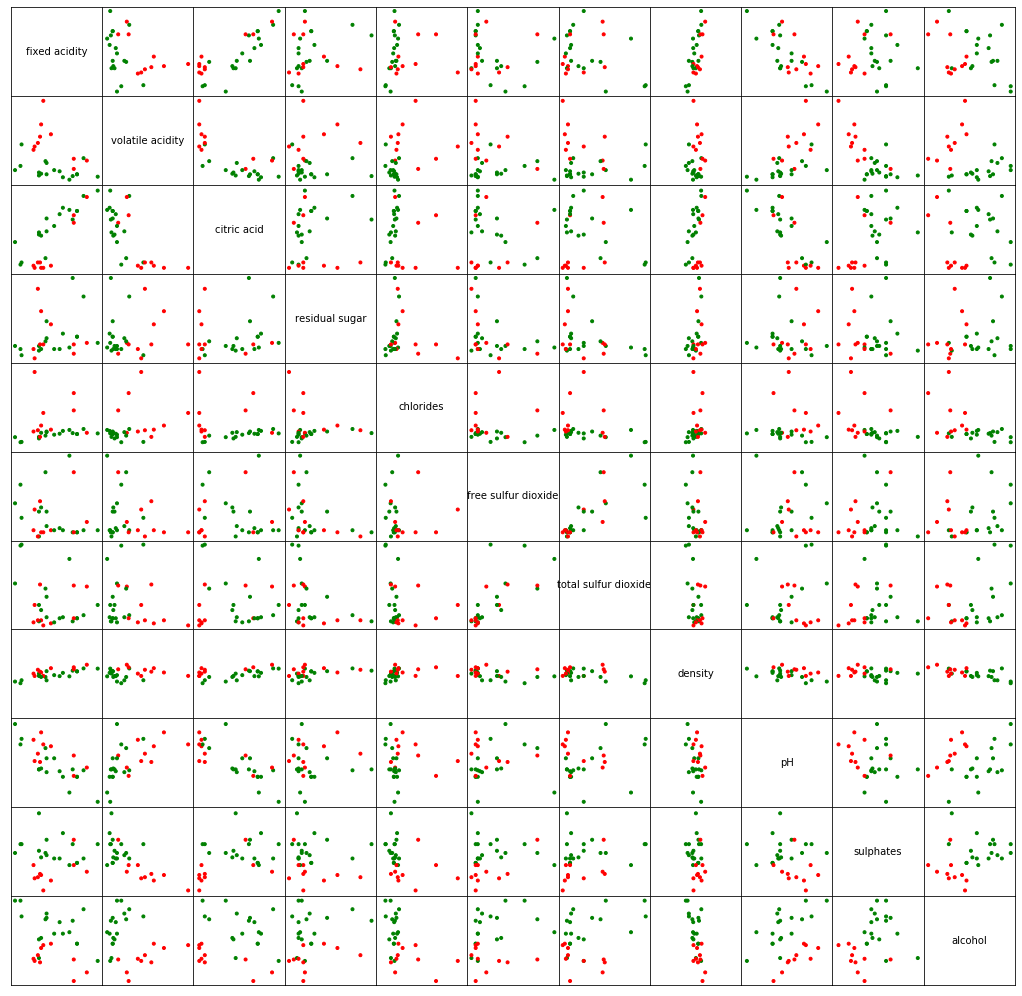

In [45]:
scatterplot_matrix(df, 7, 4, True)

#### b) Which factors do you think will be most useful to your perceptron for distinguishing high quality vs. low quality wines? Why?
We better choose the characteristics that most affect the quality of the wine. The graphs show that the highest quality of wine depends on:
* Alcohol - The more alcohol, the better the wine,
* Sulphates - The more sulfates, the better the wine,
* Volatile acidity - The lower the volatile acidity, the better the wine

# V.2 Learning to perceptron

#### a) Implementing a perceptron that:
* Has randomly initialized weights and bias
* Uses the Rosenblatt perceptron learning rule (with changeable learning rate)
* Utilizes the heaviside step activation function (discrete version)

#### b) Implementing a function to train perceptron

In [3]:
class Perceptron(object):
    
    def __init__(self, data, seed = None):
        self.data    = data
        
        if seed:
            random.seed(seed)
            
        self.bias    = random.uniform(-1, 1)
        self.weights = [random.uniform(-1, 1) for i in range(data.shape[1] - 1)]
        print(self.weights)
        
    def predict(self, input_row):
        summ = self.bias
        for i, value in enumerate(input_row):
            summ += value * self.weights[i]
        return 1.0 if summ > 0.0 else 0.0

    def train_epoch(self):
        epoch_error = 0.0
        for row in self.data:
#             print(row)
            true_answer = row[-1]
            prediction = self.predict(row[:-1])
            error = true_answer - prediction
            epoch_error += error**2
            self.bias += self.learning_rate * error
            for i, value in enumerate(row[:-1]):
                self.weights[i] += self.learning_rate * error * value
        return epoch_error

    def train_data(self, a_epochs, learning_rate, verbose=False):
        self.learning_rate = learning_rate
        current_epoch = 0
        performance = []
#         print(self.weights)
        
        while True:
            epoch_error = self.train_epoch()
            
            tuple = (current_epoch, epoch_error, self.weights, self.bias)
            performance.append(tuple)
            if (verbose):
                print(tuple)
            
            if (a_epochs == 0):
                if epoch_error == 0:
                    break
            else:
                if current_epoch >= a_epochs:
                    break
            current_epoch += 1
               
        return performance
        

In [158]:
columns_to_loc = ['alcohol', 'pH', 'goodness']
bad_quality = 4
good_quality = 7

if good_quality < bad_quality:
    raise ValueError('Good threshold is smaller to bad_threshold')
wine_data = df[(df['quality'] > good_quality) | (df['quality'] < bad_quality)]
wine_data = wine_data.assign(goodness = pd.Series(wine_data['quality'] > good_quality, dtype=int))
wine_data = wine_data.reset_index(drop=True)
selected_data = wine_data.loc[:, columns_to_loc]
print(selected_data)

    alcohol    pH  goodness
0     12.80  3.35         1
1     12.60  3.23         1
2     12.90  3.56         1
3      9.80  2.88         1
4     13.40  3.22         1
5      9.00  3.25         0
6     11.70  3.15         1
7     11.00  3.15         1
8     11.00  3.15         1
9      8.40  3.16         0
10    14.00  3.72         1
11    10.70  3.63         0
12    12.70  3.46         1
13     9.90  3.38         0
14    11.00  3.48         0
15    12.50  3.21         1
16    11.80  2.98         1
17    13.10  3.20         1
18    11.70  3.35         1
19    14.00  3.50         1
20    10.90  3.50         0
21     9.80  3.32         0
22    10.00  3.23         1
23    11.30  3.23         1
24     9.70  3.31         0
25    10.20  3.40         0
26     9.95  3.55         0
27    11.40  3.24         1


In [159]:
new_percetpron = Perceptron(selected_data.values)

performance = new_percetpron.train_data(0, 0.005, False)

print(performance[-1])

print(new_percetpron.predict([12.80, 3.35])) #1
print(new_percetpron.predict([10.20, 3.40])) #0
print(new_percetpron.predict([11.80, 2.98])) #1
print(new_percetpron.predict([14.00, 3.72])) #1
print(new_percetpron.predict([9.80, 3.32])) #0


[0.007028652117115897, -0.33831288065782217]
(12387, 0.0, [0.8630286521171497, -3.6283128806553626], 3.0901329003121223)
1.0
0.0
1.0
1.0
0.0


#### c) Function to check if perceptron works correctly
* The first plot show the number of errors perceptron made in each epoch
* The second plot show the decision boundary of our perceptron and also show ‘good’ and ‘bad’ wine data points on the final training epoch. This second plot also shade ‘good’ and ‘bad’ areas!

In [155]:
def plot_errors(ax, performance):
    epochs = [i[0] for i in performance]
    errors = [i[1] for i in performance]
    ax.plot(epochs, errors)
#     ax.set_xlim([0, len(performance)])
#     ax.set_ylim(ymin=-1)
    ax.set_title('Errors count by epochs')
    ax.set_xlabel('epoch')
    ax.set_ylabel('error')
    
def plot_boundary_decision(ax, wine_data, performance, epoch):
    x_name = columns_to_loc[1]
    y_name = columns_to_loc[0]
    x = wine_data.loc[:, x_name]
    y = wine_data.loc[:, y_name]

    x_min = x.min() - ((x.min() * 7) / 100)
    x_max = x.max() + ((x.min() * 5) / 100)
    y_min = y.min() - ((x.min() * 1) / 100)
    y_max = y.max() + ((x.min() * 1) / 100)
    
    w2, w1 = performance[epoch][2]
    b = performance[epoch][3]

    slope = -w1/w2
    intercept = -b/w2
    x_coords = range(int(x_min) - 1, int(x_max) + 2)
    y_coords = slope * x_coords + intercept

    ax.set_title('Decision boundary on epoch: ' + str(performance[epoch][0]))
    ax.set_xlabel(x_name)
    ax.set_xlim([x_min, x_max])
    ax.set_ylabel(y_name)
    ax.set_ylim([y_min, y_max])

    ax.plot(x_coords, y_coords, 'b--', label='Decision boundary')
    ax.fill_between(x_coords, y_coords, y_max, color='#99ff99')
    ax.fill_between(x_coords, y_coords, y_min, color='#ff9999')
    
def draw_scatter(ax, wine_data):
    good_wines = wine_data[(wine_data['goodness'] == 1)]
    bad_wines = wine_data[(wine_data['goodness'] == 0)]

    ax.scatter(good_wines.loc[:, columns_to_loc[1]], good_wines.loc[:, columns_to_loc[0]],
                    c=['g'], label='good wines (> {} score)'.format(good_quality))
    ax.scatter(bad_wines.loc[:, columns_to_loc[1]], bad_wines.loc[:, columns_to_loc[0]],
                    c=['r'], label='bad wines (< {} score)'.format(bad_quality))
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
    
def plot_performance(performance, wine_data, epoch=-1, save_plot=False):
    if epoch > len(performance) - 1:
        raise ValueError('number of epochs should be less than {}'.format(len(performance)))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))
    plot_errors(axes[0], performance)
    plot_boundary_decision(axes[1], wine_data, performance, epoch)
    draw_scatter(axes[1], wine_data)

    if (save_plot == True):
        plt.savefig("plot_performance.png")
    plt.show()

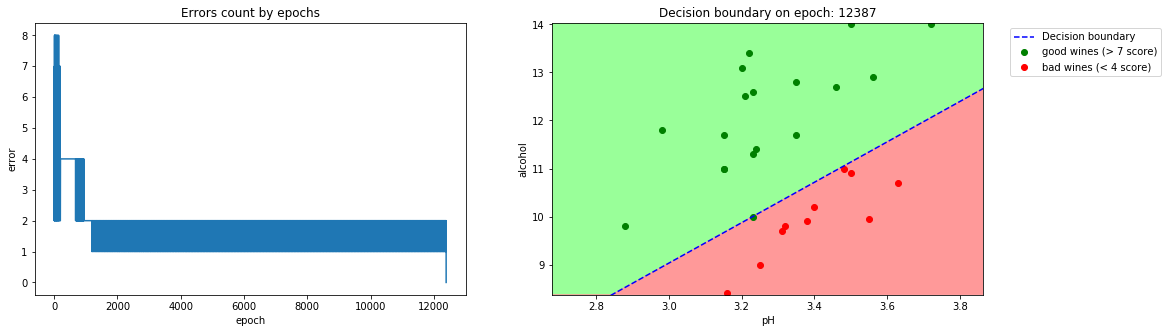

In [160]:
plot_performance(performance, selected_data, -1, True)

#### d) Make perceptron learning more efficiently (Feature Scaling)

In [6]:
def normalize(column):
    return (column - column.mean()) / (column.max() - column.min())

In [44]:
normalized_data = wine_data.loc[:, columns_to_loc]
# print(normalize_data)
for column in columns_to_loc[: -1]:
    normalized_data[column] = normalize(normalized_data[column])
#     normalize_data[column] = normalize(normalize_data[column])
#     print(normalize_data[column])
# print(normalized_data)

In [17]:
# print("Original data performance:")
# new_percetpron = Perceptron(selected_data.values, 1000)
# performance = new_percetpron.train_data(0, 0.005, False)
# print(performance[-1], '\n')

print("Normalized data performance:")
normalized_percetpron = Perceptron(normalized_data.values)
normalized_performance = normalized_percetpron.train_data(0, 0.005, False)
print(normalized_performance[-1])

Normalized data performance:
[-0.9042249670801166, 0.865924800150101]
(84, 0.0, [0.04240290281784129, -0.03463855019003226], 0.00689176236713433)


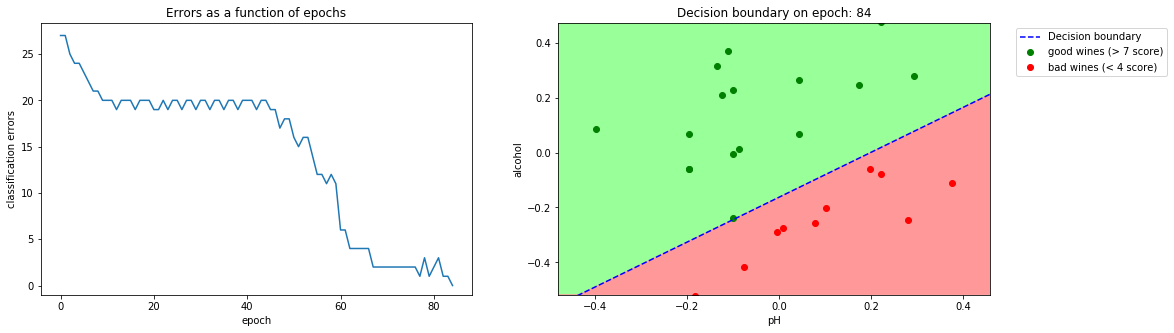

In [18]:
plot_performance(normalized_performance, normalized_data, -1, True)

# V.3 My fair ADALINE

#### a) Marvin notices and chides you for torturing your perceptron.

We can try to train our perceptron with quality higher then 6 or lower then 5. In this case perceptron couldn't find correct weights combination to avoid mistakes. This happens because perceptron algorithm works only with linear correlations and it will never found correct parameters to satisfy not linear formula

In [161]:
columns_to_loc = ['volatile acidity', 'alcohol', 'goodness']
bad_quality = 5
good_quality = 6

if good_quality < bad_quality:
    raise ValueError('Good threshold is smaller to bad_threshold')
wine_data = df[(df['quality'] > good_quality) | (df['quality'] < bad_quality)]
wine_data = wine_data.assign(goodness = pd.Series(wine_data['quality'] > good_quality, dtype=int))
wine_data = wine_data.reset_index(drop=True)
selected_data = wine_data.loc[:, columns_to_loc]

# for column in columns_to_loc[: -1]:
selected_data[columns_to_loc[0]] = normalize(selected_data[columns_to_loc[0]])

print(selected_data)

     volatile acidity  alcohol  goodness
0            0.118334    10.00         1
1            0.070389     9.50         1
2           -0.135091    10.50         1
3            0.077238     9.00         0
4           -0.066597     9.70         1
..                ...      ...       ...
275         -0.155638    10.90         1
276         -0.073447    11.20         1
277         -0.080296    11.40         1
278          0.056690    10.55         1
279         -0.107693    11.60         1

[280 rows x 3 columns]


[-0.5894355776266731, 0.760162653569356]


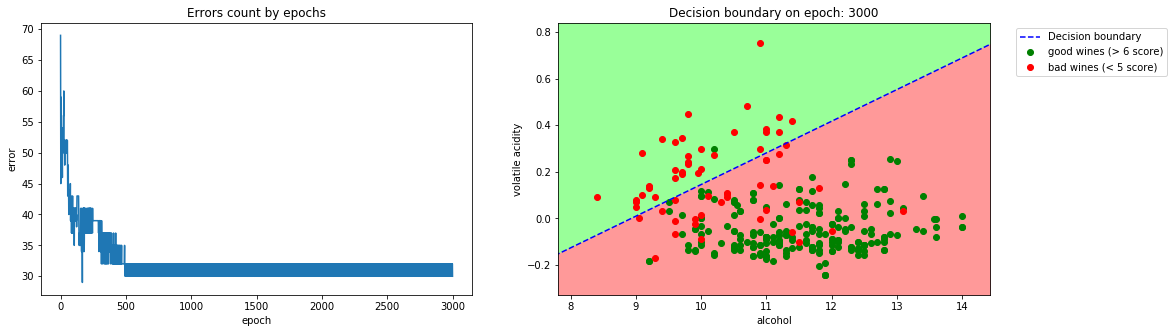

In [157]:
new_percetpron = Perceptron(selected_data.values)
performance = new_percetpron.train_data(3000, 0.005, False)
plot_performance(performance, selected_data, -1, True)

#### b), c) Implement an ADALINE with training function

The adaline network may be trained using the delta learning rule. The delta learning rule may also b called as least mean square (LMS) rule or   Widrow-Hoff rule. This learning rule is found to minimize the mean-squared error between the activation and the target value

In [176]:
class Adaline(object):
    
    def __init__(self, data, seed = None):
        self.data    = data
        
        if seed:
            random.seed(seed)
            
        self.bias    = 0.0001 * random.uniform(-1, 1)
        self.weights = [0.0001 * random.uniform(-1, 1) for i in range(data.shape[1] - 1)]
#         print(self.weights)
        
    def quantizer(self, predict):
        return 1 if predict > 0.5 else 0

    def predict(self, input_row):
        summ = self.bias
        for i, value in enumerate(input_row):
            summ += value * self.weights[i]
        return 1 / (1 + math.exp(-(summ)))

    def train_epoch(self):        
        epoch_error = 0.0
        for row in self.data:
#             print(row)
            true_answer = row[-1]
            prediction = self.predict(row[:-1])
            error = true_answer - prediction
            epoch_error += self.quantizer(prediction) != true_answer
#             epoch_errors.append(error)
            
            self.bias += self.learning_rate * error
            for i, value in enumerate(row[:-1]):
                self.weights[i] += self.learning_rate * error * value
#             print(self.bias, self.weights)
        return epoch_error

    def train_data(self, a_epochs, learning_rate, verbose=False):
        self.learning_rate = learning_rate
        current_epoch = 0
        performance = []
#         print(self.weights)
        
        while True:
            epoch_error = self.train_epoch()
            
            tuple = (current_epoch, epoch_error, self.weights, self.bias)
            performance.append(tuple)
            if (verbose):
                print('Current epoch = {}, errors = {}'.format(
                    current_epoch, epoch_error))
            
            if (a_epochs == 0):
                if epoch_error == 0:
                    break
            else:
                if current_epoch >= a_epochs:
                    break
            current_epoch += 1
               
        return performance
        

#### d) Find a good learning rate for your ADALINE and plot number of classification errors vs. epoch and the decision boundary

The best learnign rate is 0.05

Performance with learning rate  0.0005


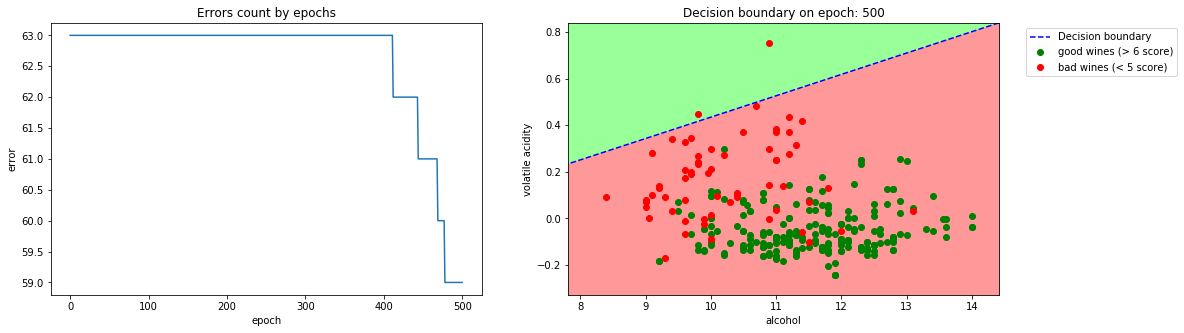

Performance with learning rate  0.005


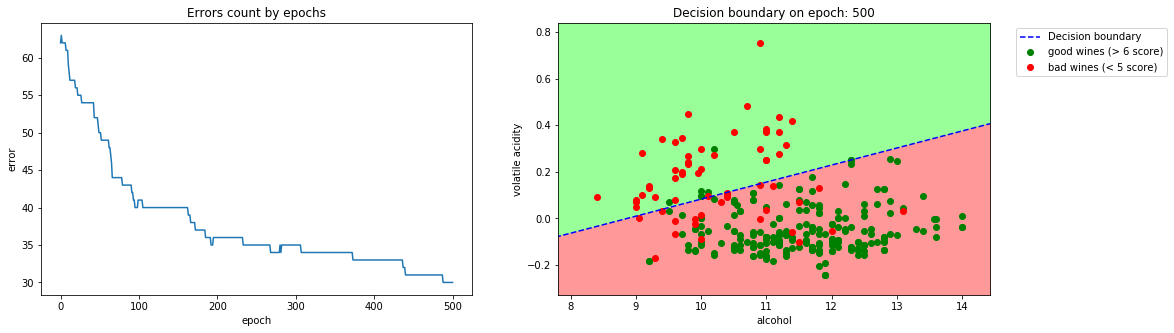

Performance with learning rate  0.05


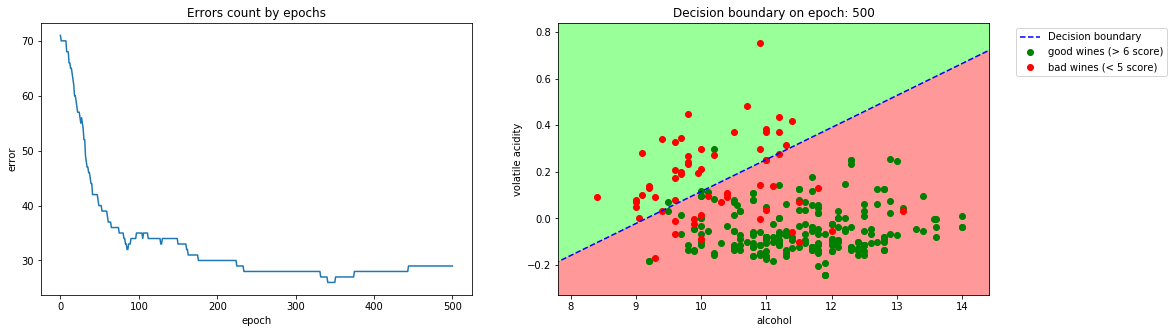

Performance with learning rate  0.5


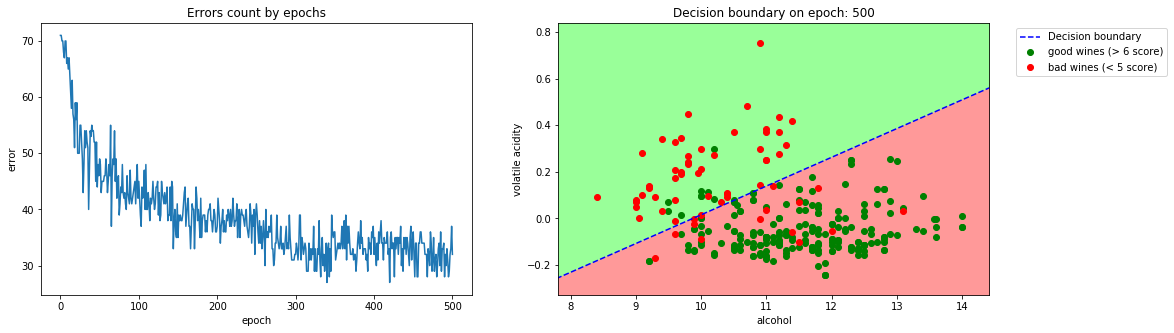

In [174]:
test_learning_rates = [0.0005, 0.005, 0.05, 0.5]

for lr in test_learning_rates:
    print("Performance with learning rate ", lr)
    adaline = Adaline(selected_data.values)
    adaline_performance = adaline.train_data(500, lr, False)
    plot_performance(adaline_performance, selected_data, -1, True)

# V.4 Advanced wine sampling and resampling

#### a) function that uses the holdout method to partition the red wine data into a training and a validation set

In [171]:
def data_partitioning(wine_data, proportion=0.7):
    train_data = wine_data.sample(frac=proportion)
    validation_data = wine_data.drop(train_data.index)

    print('Train data size: {}'.format(train_data.shape[0]))
    print('Validation data size: {}'.format(validation_data.shape[0]))
    
    return (train_data, validation_data)

Train data size: 196
Validation data size: 84


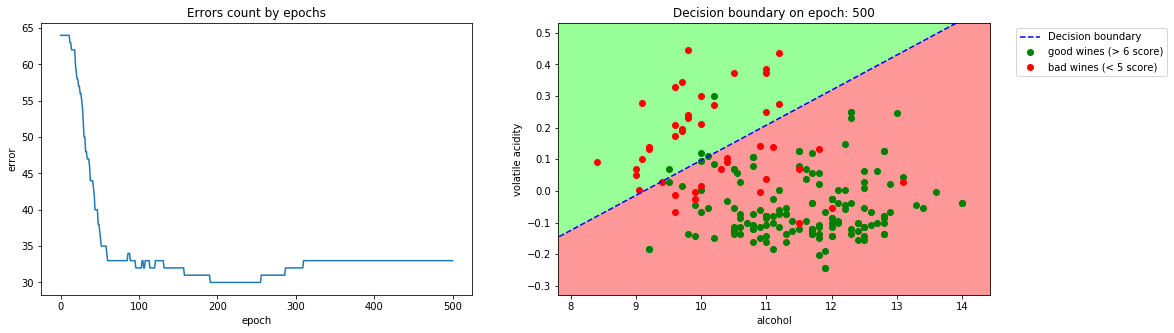

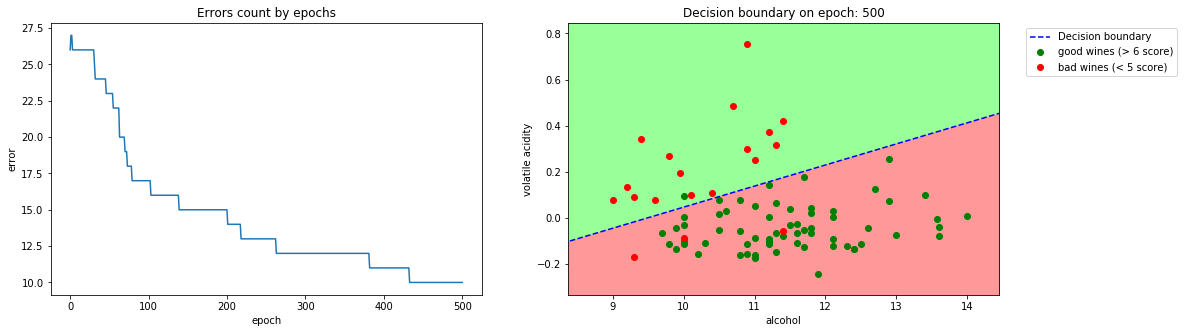

In [178]:
train_data, validation_data = data_partitioning(selected_data, 0.7)

train_adaline = Adaline(train_data.values)
validation_adaline = Adaline(validation_data.values)

train_performance = train_adaline.train_data(500, 0.05, False)
validation_performance = validation_adaline.train_data(500, 0.05, False)

plot_performance(train_performance, train_data, -1, False)
plot_performance(validation_performance, validation_data, -1, False)
